<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## GeostatsPy: Cell-based Declustering with Basic Univariate Statistics and Distribution Representativity for Subsurface Data Analytics in Python

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)

### PGE 383 Exercise: Basic Univariate Summary Statistics and Data Distribution Representativity Plotting in Python with GeostatsPy

Here's a simple workflow with some basic univariate statistics and distribution representativity. This should help you get started data declustering to address spatial sampling bias.

#### Geostatistical Sampling Representativity

In general, we should assume that all spatial data that we work with is biased.

##### Source of Spatial Sampling Bias

Data is collected to answer questions:
* how far does the contaminant plume extend? – sample peripheries
* where is the fault? – drill based on seismic interpretation
* what is the highest mineral grade? – sample the best part
* who far does the reservoir extend? – offset drilling
and to maximize NPV directly:
* maximize production rates

**Random Sampling**: when every item in the population has a equal chance of being chosen. Selection of every item is independent of every other selection.
Is random sampling sufficient for subsurface?  Is it available?
* it is not usually available, would not be economic
* data is collected answer questions
    * how large is the reservoir, what is the thickest part of the reservoir 
* and wells are located to maximize future production
    * dual purpose appraisal and injection / production wells!

**Regular Sampling**: when samples are taken at regular intervals (equally spaced).  
* less reliable than random sampling.
* Warning: may resonate with some unsuspected environmental variable.

What do we have?
* we usually have biased, opportunity sampling 
* we must account for bias (debiasing will be discussed later)

So if we were designing sampling for representativity of the sample set and resulting sample statistics, by theory we have 2 options, random sampling and regular sampling.

* What would happen if you proposed random sampling in the Gulf of Mexico at $150M per well?

We should not change current sampling methods as they result in best economics, we should address sampling bias in the data.

Never use raw spatial data without access sampling bias / correcting.

##### Mitigating Sampling Bias

In this demonstration we will take a biased spatial sample data set and apply declustering using **GeostatsPy** functionality.

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_biased.csv at https://git.io/fh0CW

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        
import warnings 
warnings.filterwarnings('ignore')         # suppress warnings

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
from statsmodels.stats.weightstats import DescrStatsW # any weighted statistics

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
os.chdir("c:/PGE383")             # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [5]:
#df = pd.read_csv('sample_data_biased.csv')     # load our data table
df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv')

No error now! It worked, we loaded our file into our DataFrame called 'df'. But how do you really know that it worked? Visualizing the DataFrame would be useful and we already leard about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [6]:
print(df.iloc[0:5,:])                   # display first 4 samples in the table as a preview
#df.head(n=13)                           # we could also use this command for a table preview

     X    Y  Facies  Porosity       Perm
0  100  900       1  0.115359   5.736104
1  100  800       1  0.136425  17.211462
2  100  600       1  0.135810  43.724752
3  100  500       0  0.094414   1.609942
4  100  100       0  0.113049  10.886001


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 2 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe()

,X,Y,Facies,Porosity,Perm
count,289.000000,289.000000,289.000000,289.000000,289.000000
mean,475.813149,529.692042,0.813149,0.134744,207.832368
std,254.277530,300.895374,0.390468,0.037745,559.359350
min,0.000000,9.000000,0.000000,0.058548,0.075819
25%,300.000000,269.000000,1.000000,0.106318,3.634086
50%,430.000000,549.000000,1.000000,0.126167,14.908970
75%,670.000000,819.000000,1.000000,0.154220,71.454424
max,990.000000,999.000000,1.000000,0.228790,5308.842566


#### Specify the Area of Interest

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [8]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25;           # range of porosity values
cmap = plt.cm.inferno                   # color map

Visualizing Tabular Data with Location Maps¶ 
Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [9]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

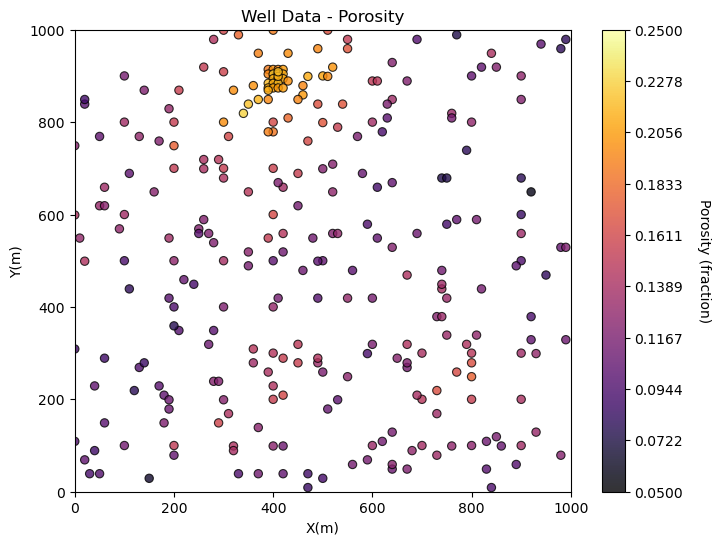

In [10]:
GSLIB.locmap(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap,'locmap_Porosity')

Look carefully, and you'll notice the the spatial samples are more dense in the high porosity regions and lower in the low porosity regions.  There is preferential sampling.  We cannot use the naive statistics to represent this region.  We have to correct for the clustering of the samples in the high porosity regions. 

Let's try cell declustering. We can interpret that we will want to minimize the declustering mean and that a cell size of between 100 - 200m is likely a good cell size, this is 'an ocular' estimate of the largest average spacing in the sparsely sampled regions.   

Let's check out the declus program reimplimented from GSLIB.

In [12]:
geostats.declus

<function geostatspy.geostats.declus(df, xcol, ycol, vcol, iminmax, noff, ncell, cmin, cmax)>

We can now populate the parameters. The parameters are:

* **df** - DataFrame with the spatial dataset
* **xcol** - column with the x coordinate
* **ycol** - column with the y coordinate
* **vcol** - column with the feature value
* **iminmax** - if 1 use the cell size that minimizes the declustered mean, if 0 the cell size that maximizes the declustered mean
* **noff** - number of cell mesh offsets to average the declustered weights over
* **ncell** - number of cell sizes to consider (between the **cmin** and **cmax**)
* **cmin** - minimum cell size
* **cmax** - maximum cell size

We will run a very wide range of cell sizes, from 10m to 2,000m ('cmin' and 'cmax') and take the cell size that minimizes the declustered mean ('iminmax' = 1 minimize, and = 0 maximize). Multiple offsets (number of these is 'noff') uses multiple grid origins and averages the results to remove sensitivity to grid position.  The ncell is the number of cell sizes.

The output from this program is:

* **wts** - an array with the weigths for each data (they sum to the number of data, 1 indicates nominal weight)
* **cell_sizes** - an array with the considered cell sizes
* **dmeans** - an array with the declustered mean for each of the **cell_sizes**

The **wts** are the declustering weights for the selected (minimizing or maximizing cell size) and the **cell_sizes** and **dmeans** are plotted to build the diagnostic declustered mean vs. cell size plot (see below).

In [13]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts'] = wts                            # add weights to the sample data DataFrame
df.head()                                  # preview to check the sample data DataFrame

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385208 


,X,Y,Facies,Porosity,Perm,Wts
0,100,900,1,0.115359,5.736104,3.064286
1,100,800,1,0.136425,17.211462,1.076608
2,100,600,1,0.135810,43.724752,0.997239
3,100,500,0,0.094414,1.609942,1.165119
4,100,100,0,0.113049,10.886001,1.224164


Let's look at the location map of the weights.

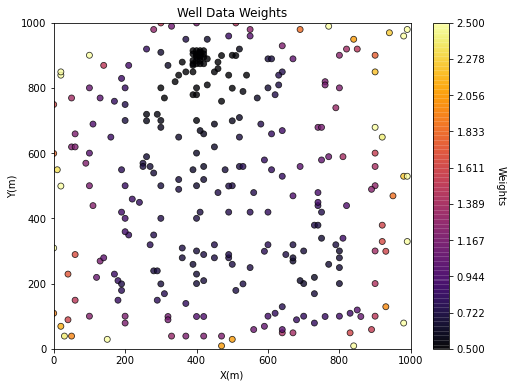

In [14]:
GSLIB.locmap(df,'X','Y','Wts',xmin,xmax,ymin,ymax,0.5,2.5,'Well Data Weights','X(m)','Y(m)','Weights',cmap,'locmap_Weights')

Does it look correct?  See the weight varies with local sampling density?  

Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

Porosity naive mean is 0.135.
Porosity declustered mean is 0.121.
Correction of 0.1002.

Summary statistics of the declustering weights:
DescribeResult(nobs=289, minmax=(0.2819756671865989, 3.984325446814365), mean=0.9999999999999996, variance=0.40927076480664726, skewness=1.9395015754905447, kurtosis=4.287460624778004)


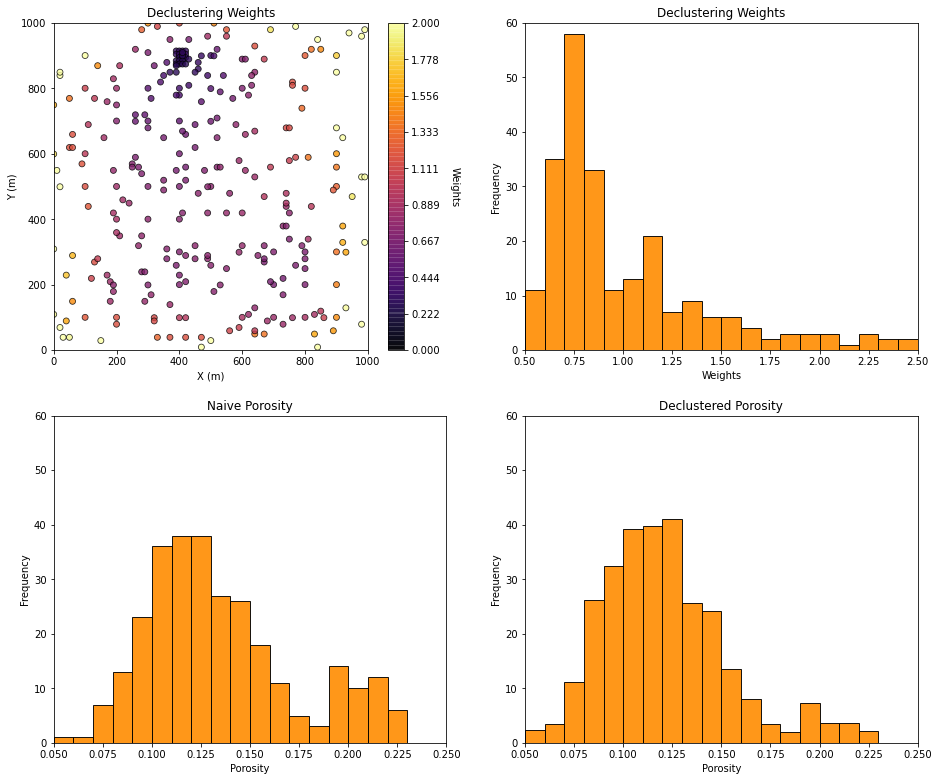

In [15]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Wts',xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(222)
GSLIB.hist_st(df['Wts'],0.5,2.5,log=False,cumul=False,bins=20,weights=None,xlabel="Weights",title="Declustering Weights")
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity")
plt.ylim(0.0,60)

plt.subplot(224)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df['Wts'],xlabel="Porosity",title="Declustered Porosity")
plt.ylim(0.0,60)

por_mean = np.average(df['Porosity'].values)
por_dmean = np.average(df['Porosity'].values,weights=df['Wts'].values)

print('Porosity naive mean is ' + str(round(por_mean,3))+'.')
print('Porosity declustered mean is ' + str(round(por_dmean,3))+'.')
cor = (por_mean-por_dmean)/por_mean
print('Correction of ' + str(round(cor,4)) +'.')

print('\nSummary statistics of the declustering weights:')
print(stats.describe(wts))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

Now let's look at the plot of the declustered porosity mean vs. the declustering cell size over the 100 runs. At very small and very large cell size the declustered mean is the naive mean. 

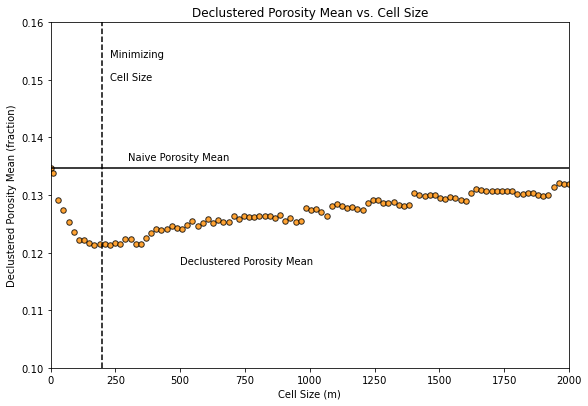

In [16]:
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.8, edgecolors = "black", facecolors = 'darkorange')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([0,2000],[por_mean,por_mean],color = 'black')
plt.plot([200,200],[0.10,0.16],color = 'black',linestyle='dashed')
plt.text(300., 0.136, r'Naive Porosity Mean')
plt.text(500., 0.118, r'Declustered Porosity Mean')
plt.text(230., 0.154, r'Minimizing')
plt.text(230., 0.150, r'Cell Size')
plt.ylim(0.10,0.16)
plt.xlim(0,2000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The cell size that minimizes the declustered mean is about 200m (estimated from the figure). This makes sense given our previous observation of the data spacing. 

#### Calculating Decustered Statistics

There are methods available to calculate weighted means, histograms and CDFs. We can always calculate weighted statistics manually.

**Weighted Variance**

\begin{equation}
\mu = \frac{1}{\sum^{n}_{j=1} w(\bf{u}_j)} \sum^{n}_{j=1} w(\bf{u}_j)x(\bf{u}_j)
\end{equation}

**Weighted Variance**

\begin{equation}
\sigma^2 = \frac{1}{\sum^{n}_{j=1} w(\bf{u}_j)} \sum^{n}_{j=1} w(\bf{u}_j)(x(\bf{u}_j)-\overline{x})^2
\end{equation}

**Weighted Standard Deviation**

\begin{equation}
\sigma = \sqrt{ \frac{1}{\sum^{n}_{j=1} w(\bf{u}_j)} \sum^{n}_{j=1} w(\bf{u}_j)(x(\bf{u}_j)-\overline{x})^2 }
\end{equation}

A convenient way to do this is with the StatsModels' DescrStatsW object that adds the weights to the data (1D or 2D) and then provides member functions for weighted statistics.

In [17]:
weighted_data = DescrStatsW(df['Porosity'].values, weights=df['Wts'], ddof=0)

print('Declustered, Weighted Statistics:')
print('  Mean: ' + str(round(weighted_data.mean,3)))
print('  Standard Deviation: ' + str(round(weighted_data.std,3)))
print('  Variance: ' + str(round(weighted_data.var,5)))

Declustered, Weighted Statistics:
  Mean: 0.121
  Standard Deviation: 0.032
  Variance: 0.00102


#### Comments

This was a basic demonstration of declustering to correct for sampling bias. Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays and many other workflows availble at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy.

I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
